## 3.4 电影评论分类：二分类问题

二分类问题可能是应用最广泛的机器学习问题。在这个例子中，你将学习根据电影评论的
文字内容将其划分为正面或负面。

### 3.4.1 IMDB 数据集

本节使用 IMDB 数据集，它包含来自互联网电影数据库（IMDB）的 50 000 条严重两极分
化的评论。数据集被分为用于训练的 25 000 条评论与用于测试的 25 000 条评论，训练集和测试
集都包含 50% 的正面评论和 50% 的负面评论。     
为什么要将训练集和测试集分开？因为你不应该将训练机器学习模型的同一批数据再用于
测试模型！模型在训练数据上的表现很好，并不意味着它在前所未见的数据上也会表现得很好，
而且你真正关心的是模型在新数据上的性能（因为你已经知道了训练数据对应的标签，显然不
再需要模型来进行预测）。例如，你的模型最终可能只是记住了训练样本和目标值之间的映射关
系，但这对在前所未见的数据上进行预测毫无用处。下一章将会更详细地讨论这一点。           
与 MNIST 数据集一样，IMDB 数据集也内置于 Keras 库。它已经过预处理：评论（单词序列）
已经被转换为整数序列，其中每个整数代表字典中的某个单词。        
下列代码将会加载 IMDB 数据集（第一次运行时会下载大约 80MB 的数据）。

#### 代码清单 3-1 加载 IMDB 数据集

In [1]:
from keras.datasets import imdb

In [2]:
(train_data,train_labels),(test_data,test_labels) = imdb.load_data(num_words=10000)

参数 num_words=10000 的意思是仅保留训练数据中前 10 000 个最常出现的单词。低频单
词将被舍弃。这样得到的向量数据不会太大，便于处理。
train_data 和 test_data 这两个变量都是评论组成的列表，每条评论又是单词索引组成
的列表（表示一系列单词）。train_labels 和 test_labels 都是 0 和 1 组成的列表，其中 0
代表负面（negative），1 代表正面（positive）。

In [3]:
train_data[0]

[1,
 14,
 22,
 16,
 43,
 530,
 973,
 1622,
 1385,
 65,
 458,
 4468,
 66,
 3941,
 4,
 173,
 36,
 256,
 5,
 25,
 100,
 43,
 838,
 112,
 50,
 670,
 2,
 9,
 35,
 480,
 284,
 5,
 150,
 4,
 172,
 112,
 167,
 2,
 336,
 385,
 39,
 4,
 172,
 4536,
 1111,
 17,
 546,
 38,
 13,
 447,
 4,
 192,
 50,
 16,
 6,
 147,
 2025,
 19,
 14,
 22,
 4,
 1920,
 4613,
 469,
 4,
 22,
 71,
 87,
 12,
 16,
 43,
 530,
 38,
 76,
 15,
 13,
 1247,
 4,
 22,
 17,
 515,
 17,
 12,
 16,
 626,
 18,
 2,
 5,
 62,
 386,
 12,
 8,
 316,
 8,
 106,
 5,
 4,
 2223,
 5244,
 16,
 480,
 66,
 3785,
 33,
 4,
 130,
 12,
 16,
 38,
 619,
 5,
 25,
 124,
 51,
 36,
 135,
 48,
 25,
 1415,
 33,
 6,
 22,
 12,
 215,
 28,
 77,
 52,
 5,
 14,
 407,
 16,
 82,
 2,
 8,
 4,
 107,
 117,
 5952,
 15,
 256,
 4,
 2,
 7,
 3766,
 5,
 723,
 36,
 71,
 43,
 530,
 476,
 26,
 400,
 317,
 46,
 7,
 4,
 2,
 1029,
 13,
 104,
 88,
 4,
 381,
 15,
 297,
 98,
 32,
 2071,
 56,
 26,
 141,
 6,
 194,
 7486,
 18,
 4,
 226,
 22,
 21,
 134,
 476,
 26,
 480,
 5,
 144,
 30,
 5535,
 18,

In [4]:
train_labels[0]

1

由于限定为前 10 000 个最常见的单词，单词索引都不会超过 10 000。

In [3]:
max([max(sequence) for sequence in train_data])

9999

下面这段代码很有意思，你可以将某条评论迅速解码为英文单词。

In [4]:
word_index = imdb.get_word_index() #word_index 是一个将单词映射为整数索引的字典
reverse_word_index = dict(
    [(value,key) for (key,value) in word_index.items()]
)
decode_review=''.join(
    [reverse_word_index.get(i - 3,'?') for i in train_data[0]]
)

### 3.4.2　准备数据

你不能将整数序列直接输入神经网络。你需要将列表转换为张量。转换方法有以下两种。          
 填充列表，使其具有相同的长度，再将列表转换成形状为 (samples, word_indices)
的整数张量，然后网络第一层使用能处理这种整数张量的层（即 Embedding 层，本书
后面会详细介绍）。      
 对列表进行 one-hot 编码，将其转换为 0 和 1 组成的向量。举个例子，序列 [3, 5] 将会
被转换为 10 000 维向量，只有索引为 3 和 5 的元素是 1，其余元素都是 0。然后网络第
一层可以用 Dense 层，它能够处理浮点数向量数据。        
下面我们采用后一种方法将数据向量化。为了加深理解，你可以手动实现这一方法，如下
所示。     

#### 代码清单 3-2 将整数序列编码为二进制矩阵

In [3]:
import numpy as np

In [4]:
def vectorize_sequences(sequences,dimension=10000):
    results = np.zeros((len(sequences),dimension))
    for i,sequence in enumerate(sequences):
        results[i,sequence] = 1
    return results

In [5]:
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

样本现在变成了这样：

In [8]:
x_train[0]

array([0., 1., 1., ..., 0., 0., 0.])

你还应该将标签向量化，这很简单。

In [6]:
y_train = np.asarray(train_labels).astype('float32')

In [7]:
y_test = np.asarray(test_labels).astype('float32')

现在可以将数据输入到神经网络中。

### 3.4.3　构建网络

输入数据是向量，而标签是标量（1 和 0），这是你会遇到的最简单的情况。有一类网
络在这种问题上表现很好，就是带有 relu 激活的全连接层（Dense）的简单堆叠，比如
Dense(16, activation='relu')。    
传入 Dense 层的参数（16）是该层隐藏单元的个数。一个隐藏单元（hidden unit）是该层
表示空间的一个维度。我们在第 2 章讲过，每个带有 relu 激活的 Dense 层都实现了下列张量
运算：

```python
output = relu(dot(W,input)+b)
```

16 个隐藏单元对应的权重矩阵 W 的形状为 (input_dimension, 16)，与 W 做点积相当于
将输入数据投影到 16 维表示空间中（然后再加上偏置向量 b 并应用 relu 运算）。你可以将表
示空间的维度直观地理解为“网络学习内部表示时所拥有的自由度”。隐藏单元越多（即更高维
的表示空间），网络越能够学到更加复杂的表示，但网络的计算代价也变得更大，而且可能会导
致学到不好的模式（这种模式会提高训练数据上的性能，但不会提高测试数据上的性能）。
对于这种 Dense 层的堆叠，你需要确定以下两个关键架构：        
 网络有多少层；       
 每层有多少个隐藏单元。           
第 4 章中的原则将会指导你对上述问题做出选择。现在你只需要相信我选择的下列架构：         
 两个中间层，每层都有 16 个隐藏单元；          
 第三层输出一个标量，预测当前评论的情感。           
中间层使用 relu 作为激活函数，最后一层使用 sigmoid 激活以输出一个 0~1 范围内的概率
值（表示样本的目标值等于 1 的可能性，即评论为正面的可能性）。relu（rectified linear unit，
整流线性单元）函数将所有负值归零（见图 3-4），而 sigmoid 函数则将任意值“压缩”到 [0,
1] 区间内（见图 3-5），其输出值可以看作概率值。

<img src ='imgs/3.png' class='atcenter'></img>

<p class='atcenter'> 3-4　整流线性单元函数</p>

<img src='imgs/3_5.png'></img>

图 3-6 显示了网络的结构。代码清单 3-3 是其 Keras 实现，与前面见过的 MNIST 例子类似。

<img src='imgs/3_6.png'></img>

####  代码清单 3-3 模型定义

In [8]:
from keras import models,layers
from keras.models import Sequential
from keras.layers import Dense,Input

In [9]:
model = models.Sequential()
model.add(Input(shape=(10000,))) #显式添加Input层
model.add(layers.Dense(16,activation='relu'))
model.add(layers.Dense(16,activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))

In [10]:
model.compile?

Signature:
model.compile(
    optimizer='rmsprop',
    loss=None,
    loss_weights=None,
    metrics=None,
    weighted_metrics=None,
    run_eagerly=False,
    steps_per_execution=1,
    jit_compile='auto',
    auto_scale_loss=True,
)
Docstring:
Configures the model for training.

Example:

```python
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[
        keras.metrics.BinaryAccuracy(),
        keras.metrics.FalseNegatives(),
    ],
)
```

Args:
    optimizer: String (name of optimizer) or optimizer instance. See
        `keras.optimizers`.
    loss: Loss function. May be a string (name of loss function), or
        a `keras.losses.Loss` instance. See `keras.losses`. A
        loss function is any callable with the signature
        `loss = fn(y_true, y_pred)`, where `y_true` are the ground truth
        values, and `y_pred` are the model's predictions.
        `y_true` should have shape `(batch_size, d0

In [10]:
from keras import losses
from keras import metrics
from keras import optimizers

### 编译模型

In [11]:
model.compile(
    optimizer=optimizers.RMSprop(learning_rate=0.001),
    loss = losses.binary_crossentropy, #使用二元交叉熵
    metrics=[metrics.binary_accuracy]
)

In [12]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

现在使用 512 个样本组成的小批量，将模型训练 20 个轮次（即对 x_train 和 y_train 两
个张量中的所有样本进行 20 次迭代）。与此同时，你还要监控在留出的 10 000 个样本上的损失
和精度。你可以通过将验证数据传入 validation_data 参数来完成。

In [13]:
history = model.fit(
        partial_x_train,
        partial_y_train,
        epochs=20, #将轮次设置成20个轮次
        batch_size=512,
        validation_data=(x_val,y_val) #验证集数据
)

Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - binary_accuracy: 0.6959 - loss: 0.6077 - val_binary_accuracy: 0.8292 - val_loss: 0.4388
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - binary_accuracy: 0.8858 - loss: 0.3682 - val_binary_accuracy: 0.8699 - val_loss: 0.3395
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - binary_accuracy: 0.9141 - loss: 0.2664 - val_binary_accuracy: 0.8653 - val_loss: 0.3256
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - binary_accuracy: 0.9310 - loss: 0.2161 - val_binary_accuracy: 0.8900 - val_loss: 0.2778
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - binary_accuracy: 0.9468 - loss: 0.1711 - val_binary_accuracy: 0.8886 - val_loss: 0.2746
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - binary_accuracy: 0.9573 - loss: 0.1462 - val_binary_accuracy: 0.8874 - val_loss: 0.2829
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - binary_accuracy: 0.9602 - loss: 0.1313 - val_binary_accuracy: 0.8871 - val_loss: 0.2892
Epoch 8/20
30

In [14]:
history_dict = history.history
history_dict.keys()

dict_keys(['binary_accuracy', 'loss', 'val_binary_accuracy', 'val_loss'])

In [15]:
import matplotlib.pyplot as plt

In [16]:
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

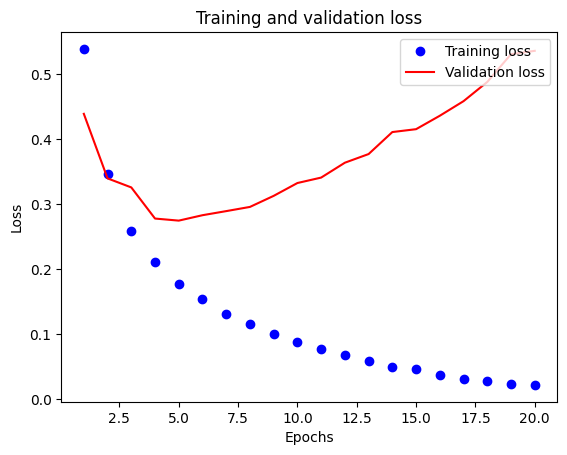

In [17]:
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

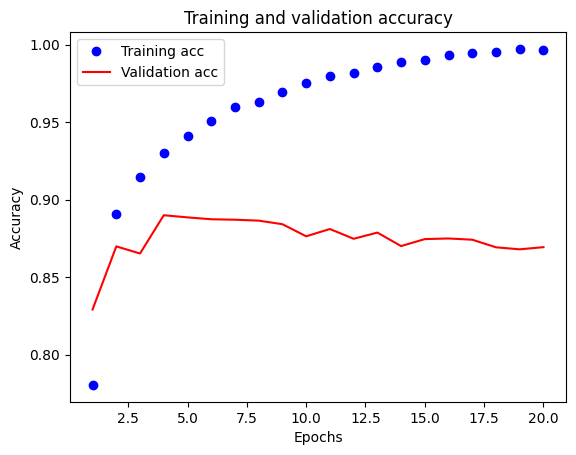

In [19]:
plt.clf()
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

如你所见，训练损失每轮都在降低，训练精度每轮都在提升。这就是梯度下降优化的预期
结果——你想要最小化的量随着每次迭代越来越小。但验证损失和验证精度并非如此：它们似
乎在第四轮达到最佳值。这就是我们之前警告过的一种情况：模型在训练数据上的表现越来越好，
但在前所未见的数据上不一定表现得越来越好。准确地说，你看到的是过拟合（overfit）：在第
二轮之后，你对训练数据过度优化，最终学到的表示仅针对于训练数据，无法泛化到训练集之
外的数据。在这种情况下，为了防止过拟合，你可以在 3 轮之后停止训练。通常来说，你可以使用许
多方法来降低过拟合，我们将在第 4 章中详细介绍。
我们从头开始训练一个新的网络，训练 4 轮，然后在测试数据上评估模型。

### 从头开始重新训练一个模型

In [20]:
model = models.Sequential()
model.add(Input(shape=(10000,)))
model.add(layers.Dense(16,activation='relu'))
model.add(layers.Dense(16,activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))

In [21]:
model.compile(
    optimizer='rmsprop',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [22]:
model.fit(x_train,y_train,epochs=4,batch_size=512)

Epoch 1/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7415 - loss: 0.5540 
Epoch 2/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8994 - loss: 0.2870 
Epoch 3/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9225 - loss: 0.2163 
Epoch 4/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9375 - loss: 0.1799 


In [23]:
results = model.evaluate(x_test,y_test)


782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8844 - loss: 0.2878


In [24]:
results

[0.28513264656066895, 0.8864799737930298]

In [25]:
model.predict(x_test)

782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step   


array([[0.25896612],
       [0.99954647],
       [0.8657573 ],
       ...,
       [0.11283432],
       [0.07228377],
       [0.546185  ]], dtype=float32)

如你所见，网络对某些样本的结果非常确信（大于等于 0.99，或小于等于 0.01），但对其他
结果却不那么确信（0.6 或 0.4）。

通过以下实验，你可以确信前面选择的网络架构是非常合理的，虽然仍有改进的空间。  
 前面使用了两个隐藏层。你可以尝试使用一个或三个隐藏层，然后观察对验证精度和测
试精度的影响。      
 尝试使用更多或更少的隐藏单元，比如 32 个、64 个等。        
 尝试使用 mse 损失函数代替 binary_crossentropy。     
 尝试使用 tanh 激活（这种激活在神经网络早期非常流行）代替 relu。     

In [26]:
model = models.Sequential()
model.add(Input(shape=(10000,)))
model.add(layers.Dense(16, activation='tanh'))
model.add(layers.Dense(32, activation='tanh'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',
             loss='mse',
             metrics=['accuracy'])
model.fit(x_train, y_train, epochs=4, batch_size=512)
results = model.evaluate(x_test, y_test)

Epoch 1/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7463 - loss: 0.1813 
Epoch 2/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9028 - loss: 0.0789 
Epoch 3/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9235 - loss: 0.0608 
Epoch 4/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9372 - loss: 0.0507 
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8806 - loss: 0.0895


In [27]:
model.predict(x_test)

782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step  


array([[0.06855503],
       [0.999674  ],
       [0.8707121 ],
       ...,
       [0.0605616 ],
       [0.04886306],
       [0.4968736 ]], dtype=float32)